In [1]:
import os ## Upload necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd 

### Creating the Dataset Class

In [2]:
data_path = "/kaggle/input/wholezip/Whole"  ## Uploading images

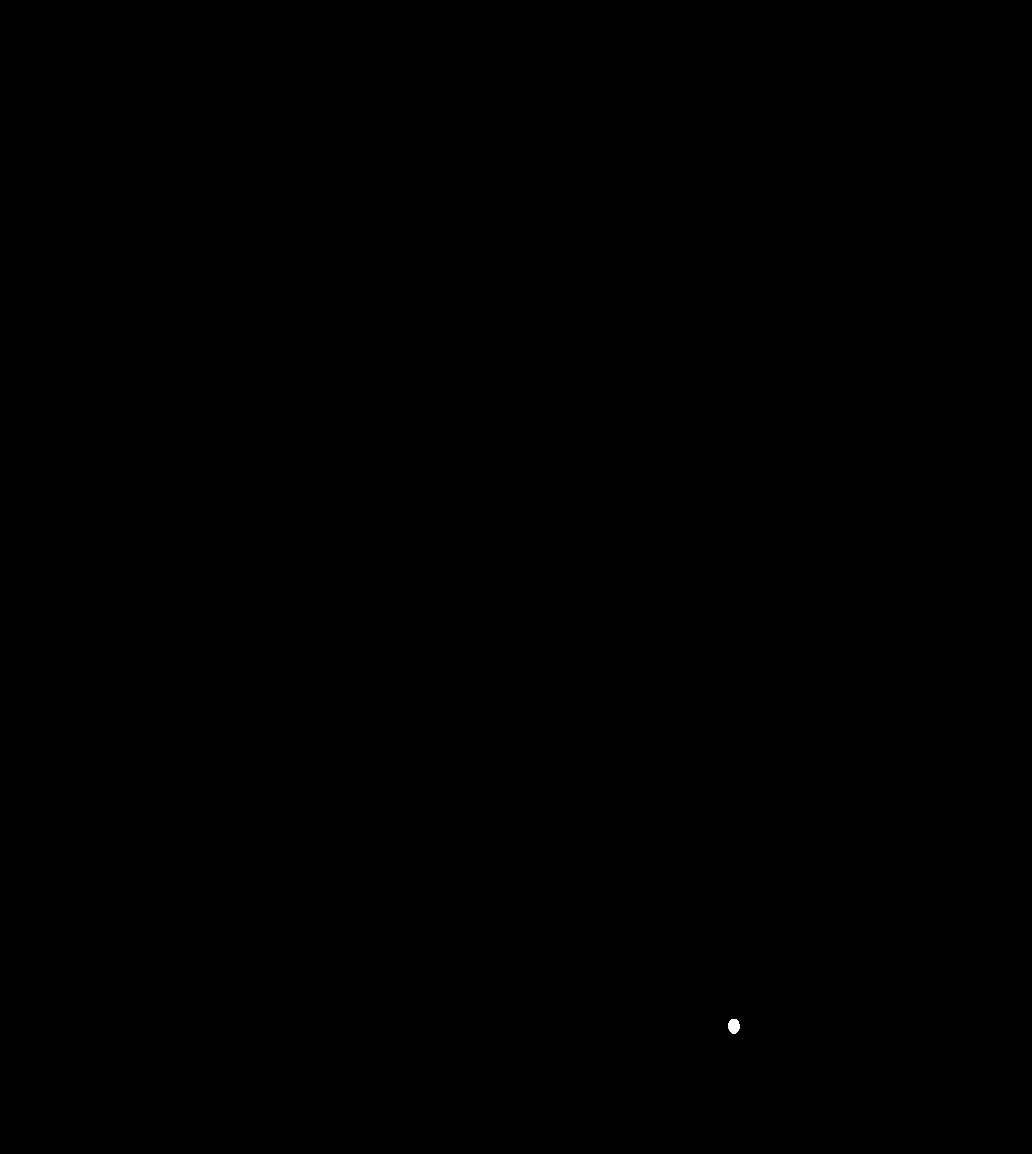

In [3]:
Image.open("/kaggle/input/wholezip/Whole/A03_00Aa_mitosis.png") ## See image

In [4]:
t.size 

(1032, 1154)

In [4]:
all_data = os.listdir(data_path)  ## List of all files

In [5]:
image_names = [image.split(".")[0] for image in  all_data if image.split(".")[-1]=="jpg"] ## Image names

In [6]:
class SegmentationDataset(Dataset):  ## Complete segmentation model
    
    def __init__(self,image_path, images,feature_extractor):
        """_summary_

        Args:
            image_path (string): _Path of the Images_
            images (_type_): _Array of name of images_
            feature_extractor (_type_): _Image feature extractor for Segformer_
        """
        
        self.image_path = image_path
        self.images = images
        self.feature_extractor = feature_extractor
        
        
    def __len__(self):
        """_summary_

        Returns:
            _int_: _length of dataset_
        """
        return len(self.images)
    
    def __getitem__(self,idx):


        image_name = self.images[idx]   
        image = Image.open(self.image_path +"/" +image_name +".jpg")  ## Normal images upload
        segmentation_mask = Image.open(self.image_path +"/" +image_name +".png") # Segmented images upload
        
        ## Encoding the data using feature extractor
        encodings = self.feature_extractor(image,segmentation_mask,return_tensors = "pt")
        
        ## Removing the dimension of the batch
        for k,v in encodings.items():
            encodings[k] = v.squeeze_()  
            
        return encodings
         

##### Initializing Segformer Feature Extractor

In [7]:
from transformers import SegformerFeatureExtractor  ## Importing SegformerFeaturEXtractor


feature_extractor = SegformerFeatureExtractor()

In [8]:
train_dataset = SegmentationDataset(data_path,image_names,feature_extractor) ## Preparing dataset

In [9]:
len(train_dataset[0]['labels'].squeeze().unique())

1

In [10]:
for i in train_dataset:  ## Labels only 0 or 255
    if (len(i['labels'].squeeze().unique()) != 1):
        print(i['labels'].squeeze().unique())
        break

tensor([  0, 255])


In [11]:
len(train_dataset)

1200

In [13]:
id2label = {0:0,1:255}
label2id = {0:0,255:1}

##### Initializing Segformer Model

In [14]:
from transformers import SegformerForSemanticSegmentation ## Importing segformer's pretrained model

In [15]:
model_name = "nvidia/mit-b0"

In [16]:
model = SegformerForSemanticSegmentation.from_pretrained(model_name,   
                                                         num_labels=2, 
                                                         id2label=id2label, 
                                                         label2id=label2id,
)

Downloading:   0%|          | 0.00/68.4k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.running_var', 'decode_head.classifier.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linea

#### Initializing Dataloaders

In [17]:
from torch.utils.data import DataLoader

In [18]:
batch_size = 16

In [19]:
len(image_names)

1200

In [20]:
t = image_names[:1080]
y = image_names[1080:1200]

In [21]:
import random   ## In followin cells, train and test datasets will be made from the original dataset.
random.shuffle(image_names)

In [22]:
train_dataset = SegmentationDataset(data_path,image_names[:1100],feature_extractor) ## Taking 100 Images for training for now

In [23]:
test_dataset =  SegmentationDataset(data_path,image_names[1100:1200],feature_extractor)

In [24]:
test_dataloader = DataLoader(test_dataset,batch_size=16,shuffle=True)

In [25]:
len(test_dataloader)

7

In [26]:
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

In [27]:
train_dataloader

#### Fine Tuning the model

In [28]:
from datasets import load_metric

metric = load_metric("mean_iou")
#metric.compute()

In [29]:
path = "/kaggle/working/Aperio_Normal_Binary.pt"
path1 = "/kaggle/working/Aperio_Normal_Binary_loss.pt"

In [30]:
maxx = 0
print(torch.cuda.is_available())


True


In [31]:
import torch
from torch import nn
#from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm


In [32]:

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("done")

done


In [35]:
ars = 0

In [33]:
maxx = 100
model.train()
for epoch in range(50):  # loop over the dataset multiple times
    metric = load_metric("mean_iou")
    
    print("Epoch:", epoch)
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].cuda()
        labels = batch["labels"].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        loss.backward()
        optimizer.step()

        # evaluate
        
    with torch.no_grad():
        
        for idx, batch in enumerate(tqdm(test_dataloader)):
    # get the inputs;
            pixel_values1 = batch["pixel_values"].cuda()
            labels1 = batch["labels"].cuda()
            outputs1 = model(pixel_values=pixel_values1, labels=labels1)
            loss, logits = outputs1.loss, outputs1.logits
            upsampled_logits = nn.functional.interpolate(logits, size=labels1.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels1.detach().cpu().numpy())
        
        # note that the metric expects predictions + labels as numpy arrays

        # let's print loss and metrics every 100 batches
        #predictions=predicted.detach().cpu().numpy()

        #metrics = metric._compute(predictions=predicted.detach().cpu().numpy(), references=labels1.detach().cpu().numpy(),num_labels=len(id2label), 
                               #ignore_index=255,
                               #reduce_labels=False, # we've already reduced the labels before)
                                # )
        metrics = metric.compute(num_labels=len(id2label), ignore_index=255, reduce_labels=False)
        ars = loss.item()
        print("Loss:", ars)
        print("Mean_iou:", metrics["mean_iou"])
        print("Mean accuracy:", metrics["mean_accuracy"])

        if maxx < ars:   ## If loss less than ars then this variable will change
            maxx = ars
            torch.save(model, path1)



Epoch: 0


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


Loss: 0.37164998054504395
Mean_iou: 0.496481795603657
Mean accuracy: 0.992963591207314
Epoch: 1


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.2994105815887451
Mean_iou: 0.4996738563618248
Mean accuracy: 0.9993477127236496
Epoch: 2


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.2379855066537857
Mean_iou: 0.4997446626072866
Mean accuracy: 0.9994893252145732
Epoch: 3


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.17172871530056
Mean_iou: 0.49985619388886404
Mean accuracy: 0.9997123877777281
Epoch: 4


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.06947745382785797
Mean_iou: 0.4999926179911116
Mean accuracy: 0.9999852359822232
Epoch: 5


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.06928367167711258
Mean_iou: 0.4999827753125937
Mean accuracy: 0.9999655506251874
Epoch: 6


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.04495310038328171
Mean_iou: 0.4999877920266445
Mean accuracy: 0.999975584053289
Epoch: 7


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.03799276426434517
Mean_iou: 0.49995568887171127
Mean accuracy: 0.9999113777434225
Epoch: 8


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.020597970113158226
Mean_iou: 0.4999989318023314
Mean accuracy: 0.9999978636046628
Epoch: 9


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.018842319026589394
Mean_iou: 0.49999965665074936
Mean accuracy: 0.9999993133014987
Epoch: 10


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Loss: 0.06016797572374344
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 11


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.017978746443986893
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 12


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.01769566535949707
Mean_iou: 0.4999990462520816
Mean accuracy: 0.9999980925041632
Epoch: 13


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.01431528851389885
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 14


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.012238274328410625
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 15


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.009875546209514141
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 16


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0097421333193779
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 17


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.008175973780453205
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 18


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.043917618691921234
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 19


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.007187606301158667
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 20


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.007723200134932995
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 21


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.007142832037061453
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 22


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.00498486403375864
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 23


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.006848142948001623
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 24


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.009143351577222347
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 25


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.013474607840180397
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 26


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0061757443472743034
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 27


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.009757015854120255
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 28


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.006764924619346857
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 29


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.008812041021883488
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 30


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0052060591988265514
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 31


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0119728222489357
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 32


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.004182713106274605
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 33


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.003344372846186161
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 34


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0033667797688394785
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 35


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0060129594057798386
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 36


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.002659732010215521
Mean_iou: 0.49999992370016655
Mean accuracy: 0.9999998474003331
Epoch: 37


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.003871917724609375
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 38


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.002055854769423604
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 39


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.002927192719653249
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 40


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.003133255522698164
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 41


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0024354313500225544
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 42


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0010724363382905722
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 43


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.01846894808113575
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 44


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0011086096055805683
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 45


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:

tv = torch.load("/kaggle/input/model1/Aperio_Normal_Binary_loss.pt")
tv.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  